<h3> Import Libraries </h3>

In [3]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import shutil
from PIL import Image

In [4]:
import pandas as pd
# import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
print(tf.__version__)
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
# import tensorflow_addons as tfa

2.9.0


In [6]:
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

<h3> Data preprocessing </h3>

In [8]:
def fft(img):
    img=np.array(img)
    f =np.fft.fft2(img.astype(np.float64)/255., axes=(0,1))
  
    # print(f.shape)
    fshift = np.fft.fftshift(f[...,0])
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # print(magnitude_spectrum.shape)
    # img_norm=(magnitude_spectrum-np.min(magnitude_spectrum))/(np.max(magnitude_spectrum)-np.min(magnitude_spectrum))
    return(magnitude_spectrum.reshape(magnitude_spectrum.shape[0],magnitude_spectrum.shape[1],1 ))
           
           


(250, 250, 1)


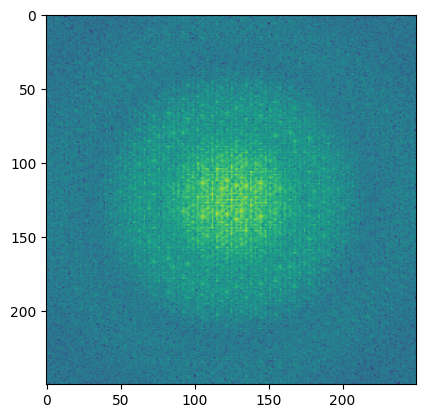

In [9]:
path='/global/cfs/cdirs/m2571/Shinjan/Atomagined/Data_raw/Training_raw/cubic/'
for file in os.listdir(path):
    img=plt.imread(path+file)
    img=fft(img)
    break
plt.imshow(img)
print(img.shape)

In [10]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1/255,
                                   preprocessing_function=fft,
                                   # height_shift_range=0.05,
                                   # width_shift_range=0.05,
                                   # rotation_range=20,
                                   # zoom_range=0.05,
                                   # brightness_range=[0.9,1.1],
                                   # fill_mode='constant',
                                   # horizontal_flip=True
                                                                            )
test_datagen = ImageDataGenerator(featurewise_center=False,
                                  featurewise_std_normalization=False,
                                  rescale=1/255,
                                  preprocessing_function=fft
                                                                            )

In [11]:
train_generator = train_datagen.flow_from_directory('/global/cfs/cdirs/m2571/Shinjan/Atomagined/Data_raw/Training_raw', 
                                                    target_size=(224, 224), 
                                                    class_mode= 'categorical', 
                                                    color_mode='grayscale', 
                                                    batch_size=32,
                                                    interpolation ='lanczos'
                                                    )
validation_generator = test_datagen.flow_from_directory('/global/cfs/cdirs/m2571/Shinjan/Atomagined/Data_raw/Validation_raw', 
                                                        target_size=(224, 224), 
                                                        class_mode= 'categorical',
                                                        color_mode='grayscale', 
                                                        batch_size=32,
                                                        interpolation ='lanczos'
                                                        )

Found 40718 images belonging to 7 classes.
Found 13574 images belonging to 7 classes.


In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

(32, 224, 224, 1)


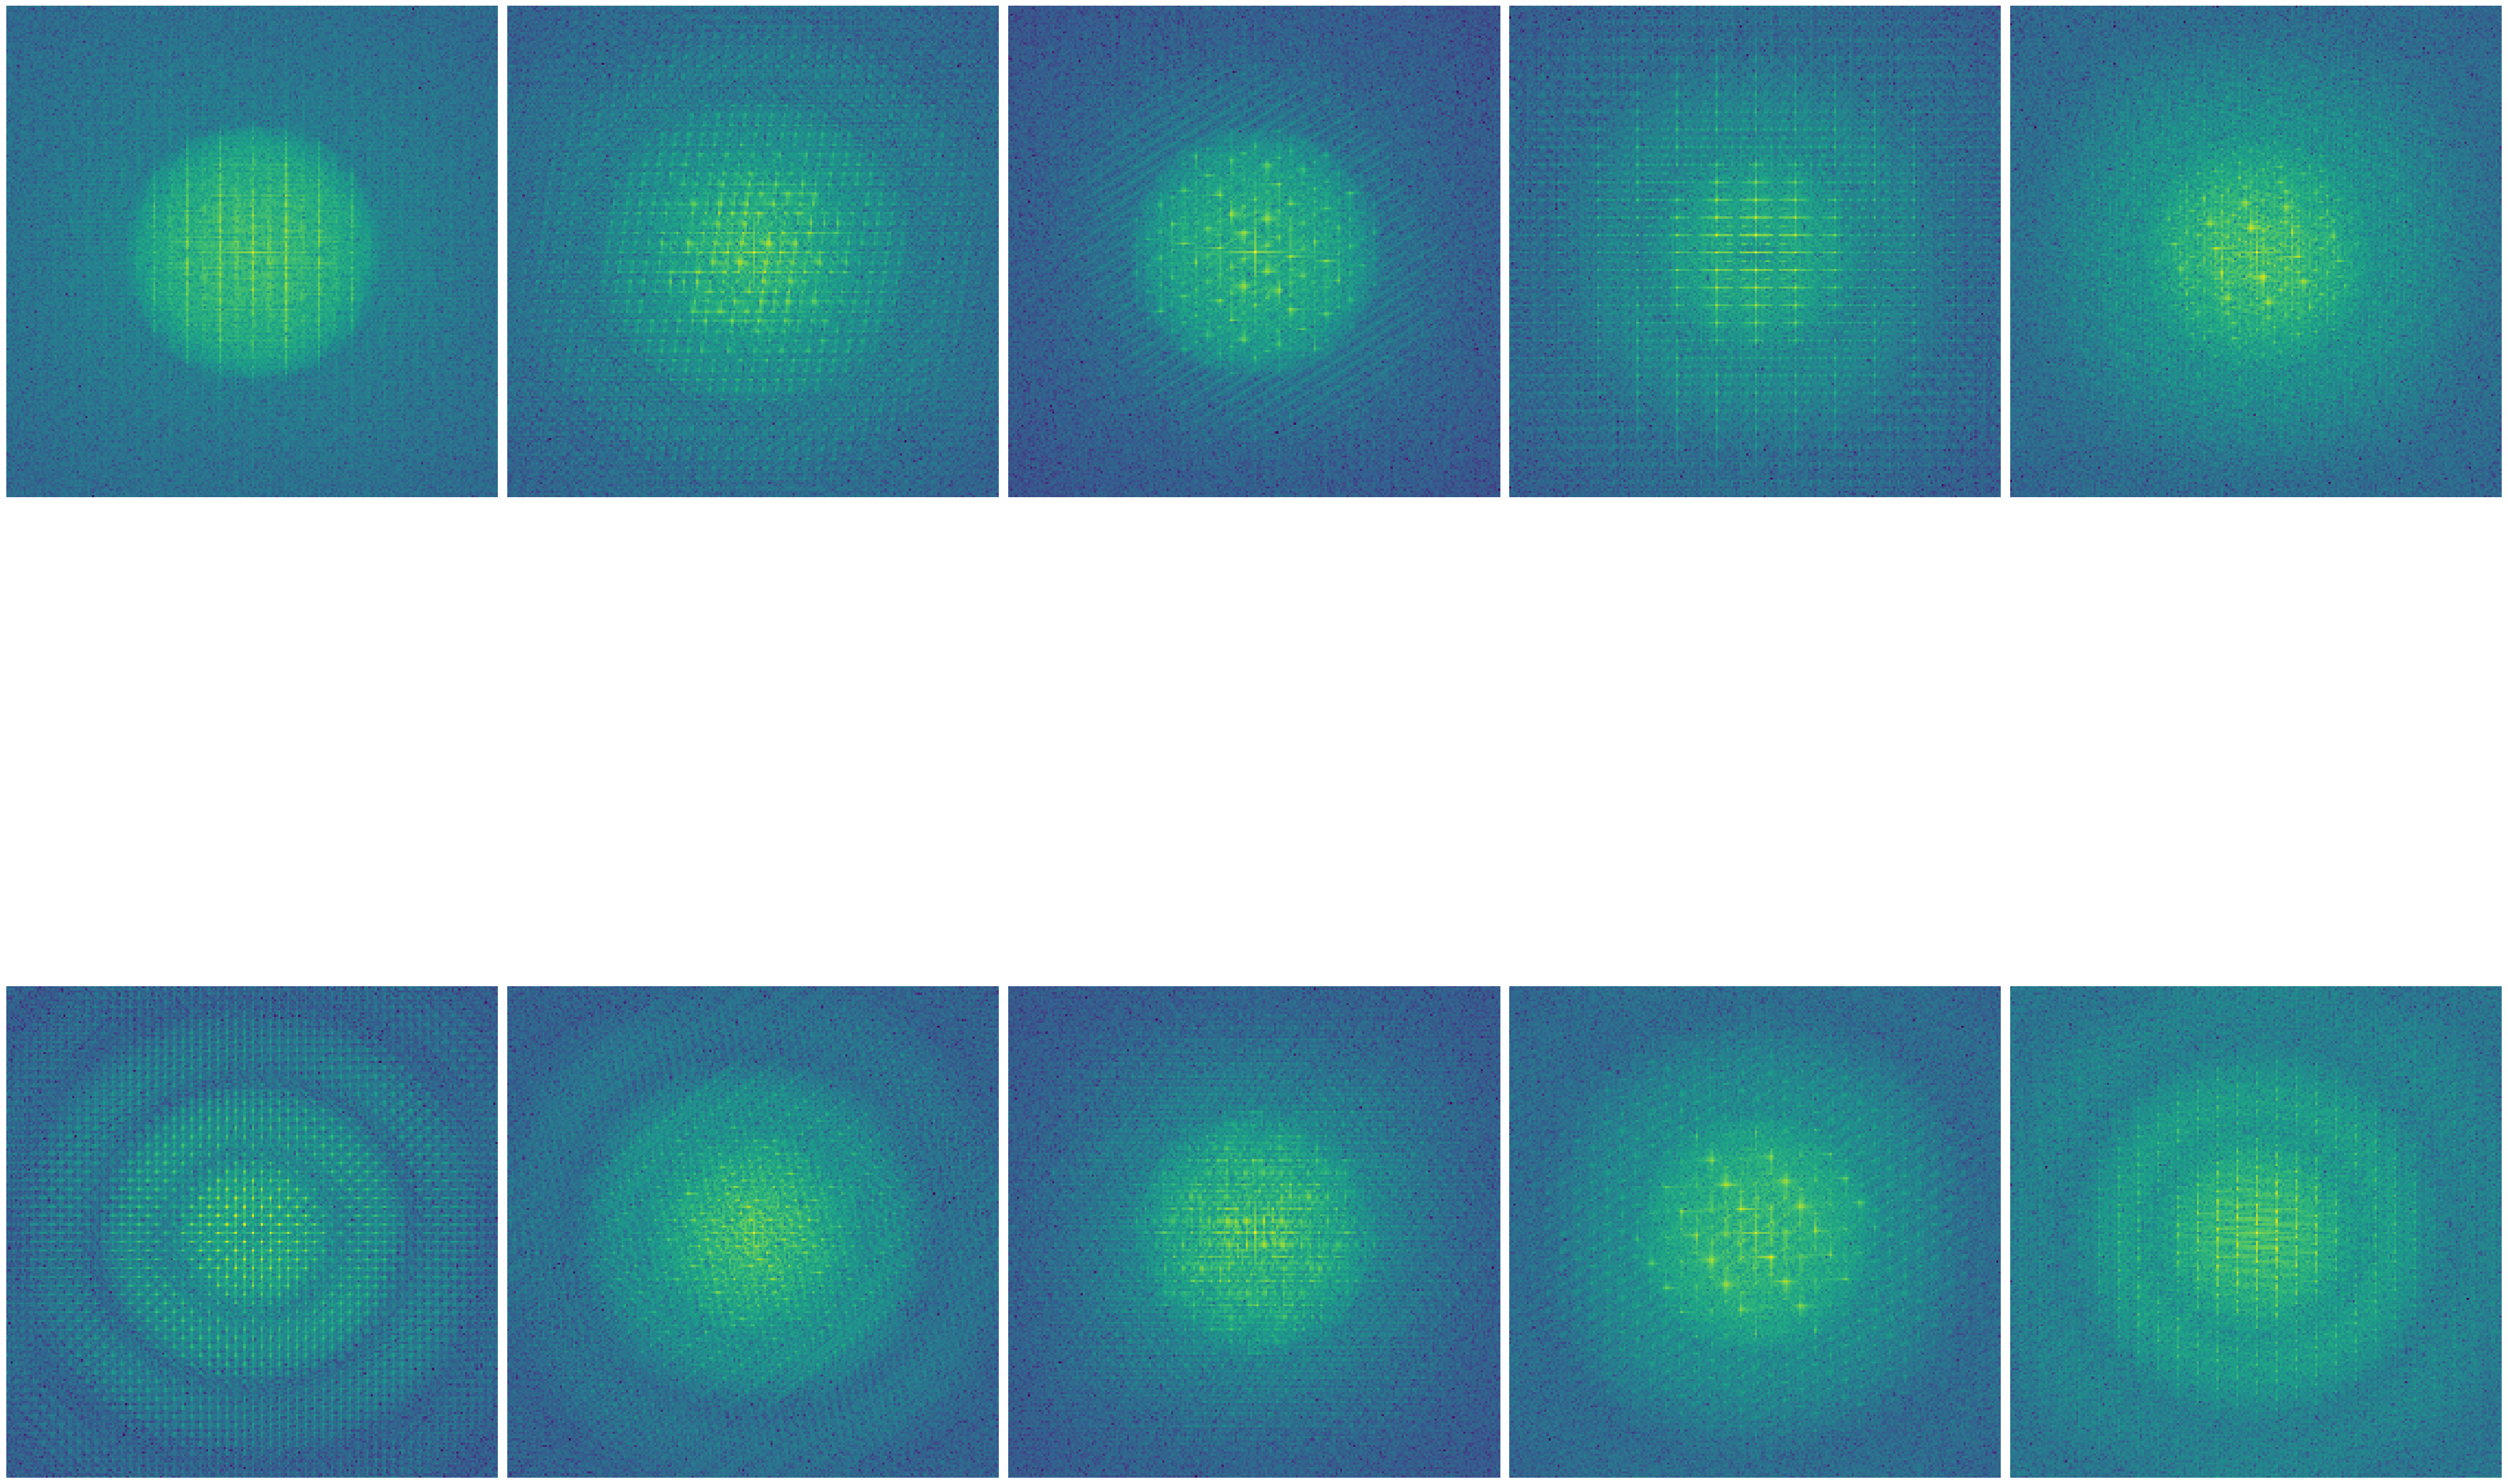

In [13]:
sample_training_images, _ = next(train_generator)
print(sample_training_images.shape)
# sample_training_images = np.multiply(sample_training_images, dataset_std)
# sample_training_images = np.add(sample_training_images, dataset_mean)
plotImages(sample_training_images)

### Build model

In [26]:
base_model = DenseNet121(
        include_top=False,
        weights=None,
        input_tensor=None,
        input_shape=(224,224,1),
        pooling=None,
        
        classifier_activation="softmax",
        )
x=base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(7, activation='softmax', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 230, 230, 1)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  3136        ['zero_padding2d_6[0][0]']       
                                )                                                           

### Freeze Convolutional Base

In [15]:
for layer in model.layers[:423]:
   layer.trainable = False
for layer in model.layers[423:]:
   layer.trainable = True

In [27]:
# model.compile(optimizer='adam', loss='categorical_crossentropy')
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001, amsgrad=True, epsilon=1.0),
              metrics=['acc',                       
                     tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])
                     # tfa.metrics.MultiLabelConfusionMatrix(num_classes=7)])


In [28]:
es = EarlyStopping(monitor='val_auc', 
                   verbose=1, 
                   patience=5, 
                   min_delta=0.001, 
                   mode='max')
mc = ModelCheckpoint('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/', 
                     monitor='val_auc', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max',
                    save_weights_only=True)
rlr = ReduceLROnPlateau(monitor='val_auc',
                        mode='max',
                        factor=0.1,
                        patience=3)

In [29]:
class_weights = {0: (40718/819)/7,        #cubic
                1: (40718/2269)/7,        #hexagonal
                2: (40718/15953)/7,       #monoclinic
                3: (40718/9712)/7,        #orthorhombic
                4: (40718/2529)/7,        #tetragonal
                5: (40718/6085)/7,        #triclinic
                6: (40718/3351)/7}        #trigonal

Epoch 1/50


2023-01-07 00:40:42.818298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-01-07 00:40:45.493829: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1273/1273 [==============================] - ETA: 0s - loss: 1.9127 - acc: 0.1790 - auc: 0.5841 - precision: 0.0769 - recall: 2.4559e-05
Epoch 1: val_auc improved from -inf to 0.72952, saving model to /global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/
1273/1273 [==============================] - 1849s 1s/step - loss: 1.9127 - acc: 0.1790 - auc: 0.5841 - precision: 0.0769 - recall: 2.4559e-05 - val_loss: 2.1792 - val_acc: 0.3820 - val_auc: 0.7295 - val_precision: 0.4258 - val_recall: 0.3007 - lr: 0.0010
Epoch 2/50
1273/1273 [==============================] - ETA: 0s - loss: 1.7871 - acc: 0.2425 - auc: 0.6880 - precision: 0.3473 - recall: 0.0086
Epoch 2: val_auc did not improve from 0.72952
1273/1273 [==============================] - 379s 298ms/step - loss: 1.7871 - acc: 0.2425 - auc: 0.6880 - precision: 0.3473 - recall: 0.0086 - val_loss: 1.8486 - val_acc: 0.1781 - val_auc: 0.7203 - val_precision: 0.2673 - val_recall: 0.1121 - lr: 0.0010
Epoch 3/50
1273/1273 [=======

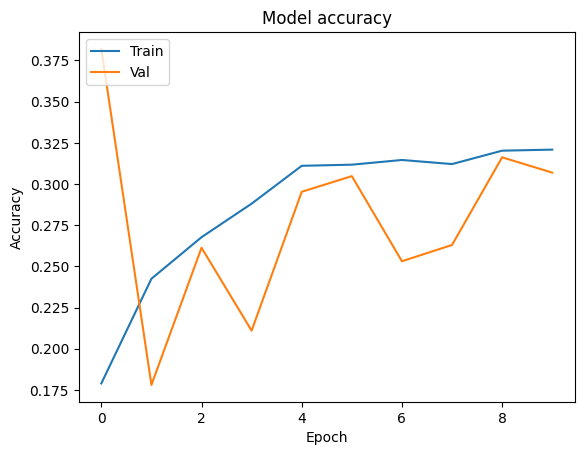

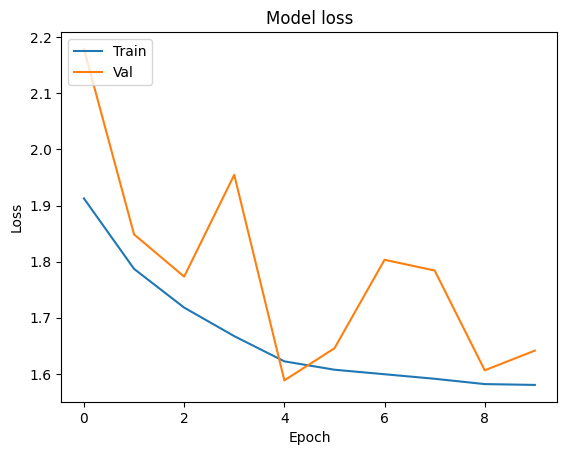

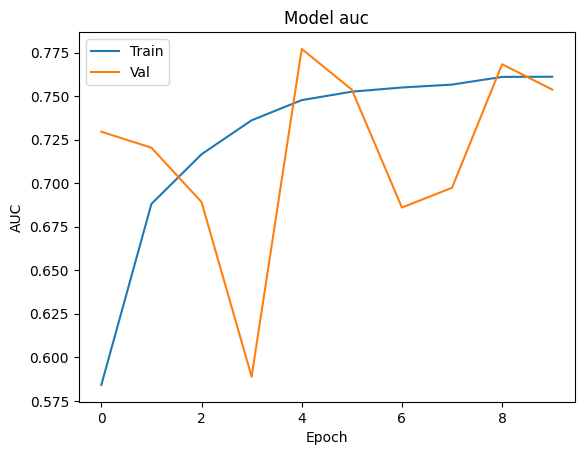

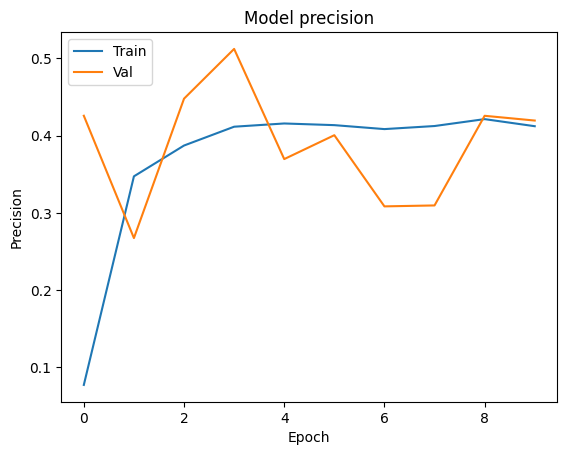

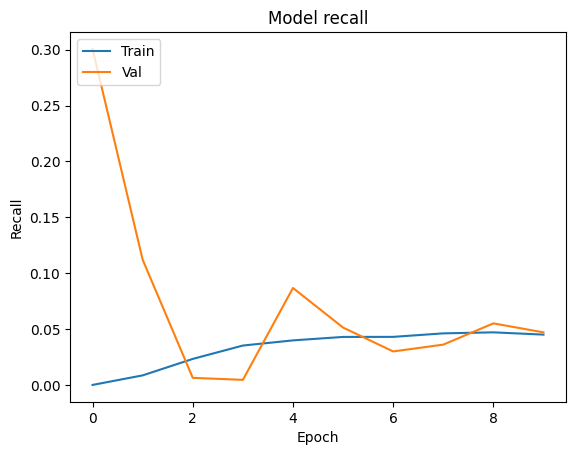

In [30]:
history= model.fit(train_generator, batch_size=32, epochs=50, validation_data=validation_generator,class_weight = class_weights, callbacks = [es, mc, rlr])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/loss.png')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/auc.png')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/precision.png')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/recall.png')
plt.show()

In [31]:
model.load_weights('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/')

In [32]:
test_generator = test_datagen.flow_from_directory(directory='/global/cfs/cdirs/m2571/Shinjan/Atomagined/Data_raw/Testing_raw', 
                                                        target_size=(224, 224), 
                                                        class_mode= 'categorical',
                                                        color_mode='grayscale', 
                                                        batch_size=200,
                                                        interpolation='lanczos',
                                                       shuffle=False)

Found 13577 images belonging to 7 classes.


In [33]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

68/68 [==============================] - 432s 6s/step


In [34]:
import seaborn as sns

In [36]:
confusion = confusion_matrix(test_generator.classes, y_pred)

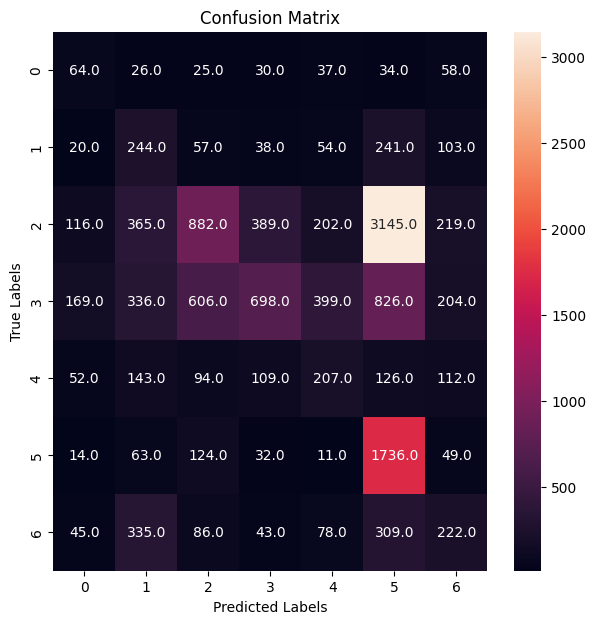

In [37]:
f, ax = plt.subplots(figsize = (7,7))
sns.heatmap(confusion, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();